# Base vs finetuned

In [ ]:
#################
#### For base vs finetuned
####
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Thai TTS WER Evaluation Script
Compares ASR transcriptions from Base vs. Fine-tuned models against reference text.
Handles Thai word tokenization and character-level fallback.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import re
from typing import Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Try to import PyThaiNLP for Thai word tokenization
try:
    from pythainlp.tokenize import word_tokenize
    PYTHAINLP_AVAILABLE = True
    print("✓ PyThaiNLP available - using Thai word tokenization")
except ImportError:
    PYTHAINLP_AVAILABLE = False
    print("⚠ PyThaiNLP not available - falling back to character-level WER")
    print("  Install with: pip install pythainlp")

# Try to import jiwer for WER computation
try:
    import jiwer
    JIWER_AVAILABLE = True
except ImportError:
    JIWER_AVAILABLE = False
    print("⚠ jiwer not available - using custom WER implementation")
    print("  Install with: pip install jiwer")

# Thai character normalization
THAI_CHARS = r'[\u0E00-\u0E7F]+'

def normalize_thai_text(text: str) -> str:
    """Normalize Thai text: lowercase, remove extra spaces, keep only Thai chars."""
    if pd.isna(text) or text is None:
        return ""

    text = str(text).strip()

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Keep only Thai characters and spaces
    text = ' '.join(re.findall(THAI_CHARS, text))

    return text.strip()

def thai_word_tokenize(text: str) -> list[str]:
    """Tokenize Thai text into words using PyThaiNLP or character-level fallback."""
    if not text:
        return []

    if PYTHAINLP_AVAILABLE:
        # Use PyThaiNLP's newmm tokenizer (best for general Thai text)
        tokens = word_tokenize(text, engine='newmm')
        # Filter out empty tokens
        tokens = [t.strip() for t in tokens if t.strip()]
        return tokens
    else:
        # Fallback: character-level tokenization
        chars = [c for c in text if c.strip()]
        return chars

def compute_wer_custom(ref: str, hyp: str, tokenize: bool = True) -> Dict:
    """
    Custom WER implementation using Levenshtein distance.
    Returns detailed error breakdown.
    """
    if tokenize:
        ref_tokens = thai_word_tokenize(ref)
        hyp_tokens = thai_word_tokenize(hyp)
    else:
        # Character-level
        ref_tokens = list(ref.replace(' ', ''))
        hyp_tokens = list(hyp.replace(' ', ''))

    # Levenshtein distance with backtracking
    r_len, h_len = len(ref_tokens), len(hyp_tokens)

    # Initialize distance matrix
    dist = np.zeros((r_len + 1, h_len + 1), dtype=int)
    for i in range(r_len + 1):
        dist[i][0] = i
    for j in range(h_len + 1):
        dist[0][j] = j

    # Fill matrix
    for i in range(1, r_len + 1):
        for j in range(1, h_len + 1):
            cost = 0 if ref_tokens[i-1] == hyp_tokens[j-1] else 1
            dist[i][j] = min(
                dist[i-1][j] + 1,      # deletion
                dist[i][j-1] + 1,      # insertion
                dist[i-1][j-1] + cost  # substitution
            )

    # Backtrack to count errors
    i, j = r_len, h_len
    substitutions = insertions = deletions = 0

    while i > 0 or j > 0:
        if i > 0 and j > 0 and dist[i][j] == dist[i-1][j-1] + (0 if ref_tokens[i-1] == hyp_tokens[j-1] else 1):
            if ref_tokens[i-1] != hyp_tokens[j-1]:
                substitutions += 1
            i -= 1
            j -= 1
        elif i > 0 and dist[i][j] == dist[i-1][j] + 1:
            deletions += 1
            i -= 1
        elif j > 0 and dist[i][j] == dist[i][j-1] + 1:
            insertions += 1
            j -= 1

    total_ref_words = len(ref_tokens)
    wer = (substitutions + deletions + insertions) / total_ref_words if total_ref_words > 0 else 0.0

    return {
        'wer': wer,
        'substitutions': substitutions,
        'deletions': deletions,
        'insertions': insertions,
        'total_ref': total_ref_words,
        'total_hyp': len(hyp_tokens),
        'ref_tokens': ref_tokens,
        'hyp_tokens': hyp_tokens
    }

def compute_wer_jiwer(ref: str, hyp: str) -> Dict:
    """Compute WER using jiwer library."""
    if not JIWER_AVAILABLE:
        return compute_wer_custom(ref, hyp)

    # Normalize and tokenize
    ref_norm = normalize_thai_text(ref)
    hyp_norm = normalize_thai_text(hyp)

    # Transform for jiwer
    transformation = jiwer.Compose([
        jiwer.RemoveMultipleSpaces(),
        jiwer.Strip(),
        jiwer.SentencesToListOfWords(word_delimiter=" ")
    ])

    # Tokenize manually for Thai
    ref_tokens = thai_word_tokenize(ref_norm)
    hyp_tokens = thai_word_tokenize(hyp_norm)

    if not ref_tokens:
        return {'wer': 1.0, 'substitutions': 0, 'deletions': 0, 'insertions': 0, 'total_ref': 0}

    try:
        wer = jiwer.wer(
            " ".join(ref_tokens),
            " ".join(hyp_tokens),
            truth_transform=transformation,
            hypothesis_transform=transformation
        )

        # Get detailed errors using alignment
        alignment = jiwer.compute_measures(
            " ".join(ref_tokens),
            " ".join(hyp_tokens)
        )

        return {
            'wer': wer,
            'substitutions': alignment['substitutions'],
            'deletions': alignment['deletions'],
            'insertions': alignment['insertions'],
            'total_ref': len(ref_tokens),
            'total_hyp': len(hyp_tokens)
        }
    except Exception as e:
        print(f"  ⚠ jiwer error: {e}, falling back to custom WER")
        return compute_wer_custom(ref, hyp)

def load_transcriptions(filepath: str) -> pd.DataFrame:
    """Load ASR transcriptions from CSV file."""
    try:
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df)} transcriptions from {filepath}")

        # Check required columns
        required_cols = ['filename', 'transcription']
        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            raise ValueError(f"Missing columns in {filepath}: {missing}")

        # Normalize transcriptions
        df['transcription_norm'] = df['transcription'].apply(normalize_thai_text)

        return df[['filename', 'transcription', 'transcription_norm']]

    except FileNotFoundError:
        print(f"✗ File not found: {filepath}")
        return pd.DataFrame()

def load_reference_texts(filepath: str) -> pd.DataFrame:
    """Load reference texts from TSyn1 evaluation set."""
    try:
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df)} reference texts from {filepath}")

        # Auto-detect text column
        text_col = None
        candidates = ['transcription', 'text', 'sentence', 'original_text']
        for col in candidates:
            if col in df.columns:
                text_col = col
                break

        if text_col is None:
            raise ValueError(f"No text column found in {filepath}. Available: {list(df.columns)}")

        print(f"  → Using text column: '{text_col}'")

        # Normalize reference texts
        df['reference_norm'] = df[text_col].apply(normalize_thai_text)

        return df[['filename', text_col, 'reference_norm']]

    except FileNotFoundError:
        print(f"✗ File not found: {filepath}")
        return pd.DataFrame()

def compute_wer_for_all(base_df: pd.DataFrame,
                       finetuned_df: pd.DataFrame,
                       ref_df: pd.DataFrame,
                       use_word_level: bool = True) -> pd.DataFrame:
    """Compute WER for all matched utterances."""

    # Merge all three datasets on filename
    merged = ref_df.merge(base_df, on='filename', how='inner', suffixes=('_ref', '_base'))
    merged = merged.merge(finetuned_df, on='filename', how='inner', suffixes=('', '_ft'))

    print(f"\n✓ Matched {len(merged)} utterances across all datasets")

    if len(merged) == 0:
        print("✗ No matching filenames found. Check filename formats.")
        return pd.DataFrame()

    # Compute WER for each utterance
    results = []

    for idx, row in merged.iterrows():
        ref_text = row['reference_norm']

        # Base model
        base_text = row.get('transcription_norm', '')
        base_wer = compute_wer_jiwer(ref_text, base_text) if JIWER_AVAILABLE else compute_wer_custom(ref_text, base_text, tokenize=use_word_level)

        # Fine-tuned model
        ft_text = row.get('transcription_norm_ft', '')
        ft_wer = compute_wer_jiwer(ref_text, ft_text) if JIWER_AVAILABLE else compute_wer_custom(ref_text, ft_text, tokenize=use_word_level)

        results.append({
            'filename': row['filename'],
            'reference': row['reference_norm'],
            'base_transcription': base_text,
            'finetuned_transcription': ft_text,
            'base_wer': base_wer['wer'],
            'finetuned_wer': ft_wer['wer'],
            'wer_improvement': base_wer['wer'] - ft_wer['wer'],
            'base_sub': base_wer['substitutions'],
            'base_del': base_wer['deletions'],
            'base_ins': base_wer['insertions'],
            'ft_sub': ft_wer['substitutions'],
            'ft_del': ft_wer['deletions'],
            'ft_ins': ft_wer['insertions'],
            'ref_length': base_wer['total_ref']
        })

        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(merged)} utterances...")

    return pd.DataFrame(results)

def generate_wer_report(results_df: pd.DataFrame, output_dir: str = 'wer_analysis'):
    """Generate comprehensive WER analysis report."""
    Path(output_dir).mkdir(exist_ok=True)

    # Overall statistics
    base_wer_mean = results_df['base_wer'].mean()
    ft_wer_mean = results_df['finetuned_wer'].mean()
    improvement = base_wer_mean - ft_wer_mean
    improvement_pct = (improvement / base_wer_mean * 100) if base_wer_mean > 0 else 0

    # Statistical significance (paired t-test)
    from scipy import stats
    t_stat, p_value = stats.ttest_rel(results_df['base_wer'], results_df['finetuned_wer'])
    significant = p_value < 0.05

    # Error type analysis
    base_total_subs = results_df['base_sub'].sum()
    base_total_dels = results_df['base_del'].sum()
    base_total_ins = results_df['base_ins'].sum()

    ft_total_subs = results_df['ft_sub'].sum()
    ft_total_dels = results_df['ft_del'].sum()
    ft_total_ins = results_df['ft_ins'].sum()

    # Summary table
    summary = pd.DataFrame({
        'Metric': [
            'Total utterances',
            'Base Model WER (mean)',
            'Fine-tuned Model WER (mean)',
            'Absolute WER improvement',
            'Relative WER improvement',
            'Paired t-test p-value',
            'Statistically significant (p<0.05)',
            '',
            'Base Model - Total Substitutions',
            'Base Model - Total Deletions',
            'Base Model - Total Insertions',
            'Fine-tuned - Total Substitutions',
            'Fine-tuned - Total Deletions',
            'Fine-tuned - Total Insertions'
        ],
        'Value': [
            len(results_df),
            f"{base_wer_mean:.4f}",
            f"{ft_wer_mean:.4f}",
            f"{improvement:.4f}",
            f"{improvement_pct:.2f}%",
            f"{p_value:.4f}",
            'YES' if significant else 'NO',
            '',
            base_total_subs,
            base_total_dels,
            base_total_ins,
            ft_total_subs,
            ft_total_dels,
            ft_total_ins
        ]
    })

    summary.to_csv(f'{output_dir}/wer_summary.csv', index=False)
    print("\n" + "="*70)
    print("WER EVALUATION SUMMARY")
    print("="*70)
    print(summary.to_string(index=False))

    # Detailed results
    results_df.to_csv(f'{output_dir}/wer_detailed_results.csv', index=False)

    # Best improvements (top 20)
    best_improvements = results_df.nlargest(20, 'wer_improvement')[[
        'filename', 'reference', 'base_wer', 'finetuned_wer', 'wer_improvement'
    ]]
    best_improvements.to_csv(f'{output_dir}/best_improvements.csv', index=False)

    # Worst cases (where fine-tuned performed worse)
    worse_cases = results_df[results_df['wer_improvement'] < -0.05].nsmallest(20, 'wer_improvement')[[
        'filename', 'reference', 'base_wer', 'finetuned_wer', 'wer_improvement'
    ]]
    worse_cases.to_csv(f'{output_dir}/worse_cases.csv', index=False)

    # WER distribution analysis
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 6))

    # Histogram of WER distributions
    plt.subplot(1, 2, 1)
    sns.histplot(results_df['base_wer'], bins=30, color='red', alpha=0.6, label='Base Model', kde=True)
    sns.histplot(results_df['finetuned_wer'], bins=30, color='green', alpha=0.6, label='Fine-tuned Model', kde=True)
    plt.xlabel('WER')
    plt.ylabel('Count')
    plt.title('WER Distribution: Base vs Fine-tuned')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Scatter plot: Base WER vs Fine-tuned WER
    plt.subplot(1, 2, 2)
    plt.scatter(results_df['base_wer'], results_df['finetuned_wer'], alpha=0.5, s=15)
    plt.plot([0, 1], [0, 1], 'r--', label='Equal performance')
    plt.xlabel('Base Model WER')
    plt.ylabel('Fine-tuned Model WER')
    plt.title('WER Comparison: Each Utterance')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{output_dir}/wer_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()

    # WER improvement histogram
    plt.figure(figsize=(10, 5))
    improvements = results_df['wer_improvement']
    sns.histplot(improvements, bins=50, kde=True, color='purple')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No improvement')
    plt.axvline(improvements.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean improvement: {improvements.mean():.3f}')
    plt.xlabel('WER Improvement (Base - Fine-tuned)')
    plt.ylabel('Count')
    plt.title('Distribution of WER Improvements')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{output_dir}/wer_improvement_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Error type comparison
    error_comparison = pd.DataFrame({
        'Error Type': ['Substitutions', 'Deletions', 'Insertions'],
        'Base Model': [base_total_subs, base_total_dels, base_total_ins],
        'Fine-tuned Model': [ft_total_subs, ft_total_dels, ft_total_ins]
    })

    error_comparison.to_csv(f'{output_dir}/error_type_comparison.csv', index=False)

    plt.figure(figsize=(10, 6))
    x = np.arange(3)
    width = 0.35
    plt.bar(x - width/2, error_comparison['Base Model'], width, label='Base Model', color='red', alpha=0.7)
    plt.bar(x + width/2, error_comparison['Fine-tuned Model'], width, label='Fine-tuned Model', color='green', alpha=0.7)
    plt.xticks(x, error_comparison['Error Type'])
    plt.ylabel('Total Errors')
    plt.title('Error Type Distribution: Base vs Fine-tuned')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{output_dir}/error_type_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f"\n✓ Analysis complete. Outputs saved to {output_dir}/")
    print(f"  • {output_dir}/wer_summary.csv")
    print(f"  • {output_dir}/wer_detailed_results.csv")
    print(f"  • {output_dir}/best_improvements.csv")
    print(f"  • {output_dir}/worse_cases.csv")
    print(f"  • {output_dir}/wer_distributions.png")
    print(f"  • {output_dir}/wer_improvement_distribution.png")
    print(f"  • {output_dir}/error_type_comparison.png")

    # Print key findings
    print("\n" + "="*70)
    print("KEY FINDINGS")
    print("="*70)
    print(f"• Fine-tuned model {'improved' if improvement > 0 else 'worsened'} WER by {abs(improvement):.4f} ({abs(improvement_pct):.2f}%)")
    print(f"• Statistical significance: {'YES (p<0.05)' if significant else 'NO (p>=0.05)'}")
    print(f"• {len(best_improvements)} utterances showed strongest improvements (saved to best_improvements.csv)")
    print(f"• {len(worse_cases)} utterances performed worse after fine-tuning (saved to worse_cases.csv)")

    if len(worse_cases) > 0:
        print(f"\n⚠️  WARNING: Fine-tuning degraded performance on {len(worse_cases)} utterances")
        print("   Check 'worse_cases.csv' to identify problematic patterns")

    print("="*70)


⚠ PyThaiNLP not available - falling back to character-level WER
  Install with: pip install pythainlp
⚠ jiwer not available - using custom WER implementation
  Install with: pip install jiwer


# Finetune vs Finetune

In [ ]:
!pip install pythainlp

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.2 MB/s eta 0:00:00


In [ ]:
#################
#### For finetuned vs finetuned
####
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Thai TTS WER Evaluation Script
Compares ASR transcriptions from Fine-tuned Model vs. Fine-tuned models with word boundary against reference text.
Handles Thai word tokenization and character-level fallback.
"""

import pandas as pd
import numpy as np
from pathlib import Path
import re
from typing import Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Try to import PyThaiNLP for Thai word tokenization
try:
    from pythainlp.tokenize import word_tokenize
    PYTHAINLP_AVAILABLE = True
    print("✓ PyThaiNLP available - using Thai word tokenization")
except ImportError:
    PYTHAINLP_AVAILABLE = False
    print("⚠ PyThaiNLP not available - falling back to character-level WER")
    print("  Install with: pip install pythainlp")

# Try to import jiwer for WER computation
try:
    import jiwer
    JIWER_AVAILABLE = True
except ImportError:
    JIWER_AVAILABLE = False
    print("⚠ jiwer not available - using custom WER implementation")
    print("  Install with: pip install jiwer")

# Thai character normalization
THAI_CHARS = r'[\u0E00-\u0E7F]+'

def normalize_thai_text(text: str) -> str:
    """Normalize Thai text: lowercase, remove extra spaces, keep only Thai chars."""
    if pd.isna(text) or text is None:
        return ""

    text = str(text).strip()

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Keep only Thai characters and spaces
    text = ' '.join(re.findall(THAI_CHARS, text))

    return text.strip()

def thai_word_tokenize(text: str) -> list[str]:
    """Tokenize Thai text into words using PyThaiNLP or character-level fallback."""
    if not text:
        return []

    if PYTHAINLP_AVAILABLE:
        # Use PyThaiNLP's newmm tokenizer (best for general Thai text)
        tokens = word_tokenize(text, engine='newmm')
        # Filter out empty tokens
        tokens = [t.strip() for t in tokens if t.strip()]
        return tokens
    else:
        # Fallback: character-level tokenization
        chars = [c for c in text if c.strip()]
        return chars

def compute_wer_custom(ref: str, hyp: str, tokenize: bool = True) -> Dict:
    """
    Custom WER implementation using Levenshtein distance.
    Returns detailed error breakdown.
    """
    if tokenize:
        # ref_tokens = thai_word_tokenize(ref)
        # hyp_tokens = thai_word_tokenize(hyp)
        hyp_tokens = thai_word_tokenize(ref)
        ref_tokens = thai_word_tokenize(hyp)
    else:
        # Character-level
        ref_tokens = list(ref.replace(' ', ''))
        hyp_tokens = list(hyp.replace(' ', ''))

    # Levenshtein distance with backtracking
    r_len, h_len = len(ref_tokens), len(hyp_tokens)

    # Initialize distance matrix
    dist = np.zeros((r_len + 1, h_len + 1), dtype=int)
    for i in range(r_len + 1):
        dist[i][0] = i
    for j in range(h_len + 1):
        dist[0][j] = j

    # Fill matrix
    for i in range(1, r_len + 1):
        for j in range(1, h_len + 1):
            cost = 0 if ref_tokens[i-1] == hyp_tokens[j-1] else 1
            dist[i][j] = min(
                dist[i-1][j] + 1,      # deletion
                dist[i][j-1] + 1,      # insertion
                dist[i-1][j-1] + cost  # substitution
            )

    # Backtrack to count errors
    i, j = r_len, h_len
    substitutions = insertions = deletions = 0

    while i > 0 or j > 0:
        if i > 0 and j > 0 and dist[i][j] == dist[i-1][j-1] + (0 if ref_tokens[i-1] == hyp_tokens[j-1] else 1):
            if ref_tokens[i-1] != hyp_tokens[j-1]:
                substitutions += 1
            i -= 1
            j -= 1
        elif i > 0 and dist[i][j] == dist[i-1][j] + 1:
            deletions += 1
            i -= 1
        elif j > 0 and dist[i][j] == dist[i][j-1] + 1:
            insertions += 1
            j -= 1

    total_ref_words = len(ref_tokens)
    wer = (substitutions + deletions + insertions) / total_ref_words if total_ref_words > 0 else 0.0

    return {
        'wer': wer,
        'substitutions': substitutions,
        'deletions': deletions,
        'insertions': insertions,
        'total_ref': total_ref_words,
        'total_hyp': len(hyp_tokens),
        'ref_tokens': ref_tokens,
        'hyp_tokens': hyp_tokens
    }

def compute_wer_jiwer(ref: str, hyp: str) -> Dict:
    """Compute WER using jiwer library."""
    # if not JIWER_AVAILABLE:
    #     return compute_wer_custom(ref, hyp)
    return compute_wer_custom(ref, hyp)

    # # Normalize and tokenize
    # ref_norm = normalize_thai_text(ref)
    # hyp_norm = normalize_thai_text(hyp)

    # # Tokenize manually for Thai
    # ref_tokens = thai_word_tokenize(ref_norm)
    # hyp_tokens = thai_word_tokenize(hyp_norm)

    # if not ref_tokens:
    #     return {'wer': 1.0, 'substitutions': 0, 'deletions': 0, 'insertions': 0, 'total_ref': 0}

    # try:
    #     wer = jiwer.wer(
    #         " ".join(ref_tokens),
    #         " ".join(hyp_tokens)
    #     )

    #     # Get detailed errors using alignment
    #     alignment = jiwer.compute_measures(
    #         " ".join(ref_tokens),
    #         " ".join(hyp_tokens)
    #     )

    #     return {
    #         'wer': wer,
    #         'substitutions': alignment['substitutions'],
    #         'deletions': alignment['deletions'],
    #         'insertions': alignment['insertions'],
    #         'total_ref': len(ref_tokens),
    #         'total_hyp': len(hyp_tokens)
    #     }
    # except Exception as e:
    #     print(f"  ⚠ jiwer error: {e}, falling back to custom WER")
    #     return compute_wer_custom(ref, hyp)

def load_transcriptions(filepath: str) -> pd.DataFrame:
    """Load ASR transcriptions from CSV file."""
    try:
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df)} transcriptions from {filepath}")

        # Check required columns
        required_cols = ['filename', 'transcription']
        missing = [col for col in required_cols if col not in df.columns]
        if missing:
            raise ValueError(f"Missing columns in {filepath}: {missing}")

        # Normalize transcriptions
        df['transcription_norm'] = df['transcription'].apply(normalize_thai_text)

        return df[['filename', 'transcription', 'transcription_norm']]

    except FileNotFoundError:
        print(f"✗ File not found: {filepath}")
        return pd.DataFrame()

def load_reference_texts(filepath: str) -> pd.DataFrame:
    """Load reference texts from TSyn1 evaluation set."""
    try:
        df = pd.read_csv(filepath)
        print(f"✓ Loaded {len(df)} reference texts from {filepath}")

        # Auto-detect text column
        text_col = None
        candidates = ['transcription', 'text', 'sentence', 'original_text']
        for col in candidates:
            if col in df.columns:
                text_col = col
                break

        if text_col is None:
            raise ValueError(f"No text column found in {filepath}. Available: {list(df.columns)}")

        print(f"  → Using text column: '{text_col}'")

        # Normalize reference texts
        df['reference_norm'] = df[text_col].apply(normalize_thai_text)

        return df[['filename', text_col, 'reference_norm']]

    except FileNotFoundError:
        print(f"✗ File not found: {filepath}")
        return pd.DataFrame()

def compute_wer_for_all(base_df: pd.DataFrame,
                       finetuned_df: pd.DataFrame,
                       ref_df: pd.DataFrame,
                       use_word_level: bool = True) -> pd.DataFrame:
    """Compute WER for all matched utterances."""

    # Merge all three datasets on filename
    merged = ref_df.merge(base_df, on='filename', how='inner', suffixes=('_ref', '_base'))
    merged = merged.merge(finetuned_df, on='filename', how='inner', suffixes=('', '_ft'))

    print(f"\n✓ Matched {len(merged)} utterances across all datasets")

    if len(merged) == 0:
        print("✗ No matching filenames found. Check filename formats.")
        return pd.DataFrame()

    # Compute WER for each utterance
    results = []

    for idx, row in merged.iterrows():
        ref_text = row['reference_norm']

        # Base model
        base_text = row.get('transcription_norm', '')
        base_wer = compute_wer_jiwer(ref_text, base_text) if JIWER_AVAILABLE else compute_wer_custom(ref_text, base_text, tokenize=use_word_level)

        # Fine-tuned model
        ft_text = row.get('transcription_norm_ft', '')
        ft_wer = compute_wer_jiwer(ref_text, ft_text) if JIWER_AVAILABLE else compute_wer_custom(ref_text, ft_text, tokenize=use_word_level)

        results.append({
            'filename': row['filename'],
            'reference': row['reference_norm'],
            'base_transcription': base_text,
            'finetuned_transcription': ft_text,
            'base_wer': base_wer['wer'],
            'finetuned_wer': ft_wer['wer'],
            'wer_improvement': base_wer['wer'] - ft_wer['wer'],
            'base_sub': base_wer['substitutions'],
            'base_del': base_wer['deletions'],
            'base_ins': base_wer['insertions'],
            'ft_sub': ft_wer['substitutions'],
            'ft_del': ft_wer['deletions'],
            'ft_ins': ft_wer['insertions'],
            'ref_length': base_wer['total_ref']
        })

        if (idx + 1) % 100 == 0:
            print(f"  Processed {idx + 1}/{len(merged)} utterances...")

    return pd.DataFrame(results)

def generate_wer_report(results_df: pd.DataFrame, output_dir: str = 'wer_analysis'):
    """Generate comprehensive WER analysis report."""
    Path(output_dir).mkdir(exist_ok=True)

    # Overall statistics
    base_wer_mean = results_df['base_wer'].mean()
    ft_wer_mean = results_df['finetuned_wer'].mean()
    improvement = base_wer_mean - ft_wer_mean
    improvement_pct = (improvement / base_wer_mean * 100) if base_wer_mean > 0 else 0

    base_wer_min = results_df['base_wer'].min()
    ft_wer_min = results_df['finetuned_wer'].min()
    improvement_min = base_wer_min - ft_wer_min
    improvement_pct_min = (improvement_min / base_wer_min * 100) if base_wer_min > 0 else 0


    # Statistical significance (paired t-test)
    from scipy import stats
    t_stat, p_value = stats.ttest_rel(results_df['base_wer'], results_df['finetuned_wer'])
    significant = p_value < 0.05

    # Error type analysis
    base_total_subs = results_df['base_sub'].sum()
    base_total_dels = results_df['base_del'].sum()
    base_total_ins = results_df['base_ins'].sum()

    ft_total_subs = results_df['ft_sub'].sum()
    ft_total_dels = results_df['ft_del'].sum()
    ft_total_ins = results_df['ft_ins'].sum()

    # Summary table
    summary = pd.DataFrame({
        'Metric': [
            'Total utterances',
            'Fine-tuned Model WER (mean)',
            'Fine-tuned Model with word boundary WER (mean)',
            'Fine-tuned Model WER (min)',
            'Fine-tuned Model with word boundary WER (min)',
            'Absolute WER improvement',
            'Relative WER improvement',
            'Paired t-test p-value',
            'Statistically significant (p<0.05)',
            '',
            'Fine-tuned - Total Substitutions',
            'Fine-tuned - Total Deletions',
            'Fine-tuned - Total Insertions',
            'Fine-tuned with word boundary - Total Substitutions',
            'Fine-tuned with word boundary - Total Deletions',
            'Fine-tuned with word boundary - Total Insertions'
        ],
        'Value': [
            len(results_df),
            f"{base_wer_mean:.4f}",
            f"{ft_wer_mean:.4f}",
            f"{base_wer_min:.4f}",
            f"{ft_wer_min:.4f}",
            f"{improvement:.4f}",
            f"{improvement_pct:.2f}%",
            f"{p_value:.4f}",
            'YES' if significant else 'NO',
            '',
            base_total_subs,
            base_total_dels,
            base_total_ins,
            ft_total_subs,
            ft_total_dels,
            ft_total_ins
        ]
    })

    summary.to_csv(f'{output_dir}/wer_summary.csv', index=False)
    print("\n" + "="*70)
    print("WER EVALUATION SUMMARY")
    print("="*70)
    print(summary.to_string(index=False))

    # Detailed results
    results_df.to_csv(f'{output_dir}/wer_detailed_results.csv', index=False)
    print("Sucessfully save wer_detailed_results.csv")

    # Best improvements (top 20)
    best_improvements = results_df.nlargest(20, 'wer_improvement')[[
        'filename', 'reference', 'base_wer', 'finetuned_wer', 'wer_improvement'
    ]]
    best_improvements.to_csv(f'{output_dir}/best_improvements.csv', index=False)
    print("Sucessfully save best_improvements.csv")

    # Worst cases (where fine-tuned performed worse)
    worse_cases = results_df[results_df['wer_improvement'] < -0.05].nsmallest(20, 'wer_improvement')[[
        'filename', 'reference', 'base_wer', 'finetuned_wer', 'wer_improvement'
    ]]
    worse_cases.to_csv(f'{output_dir}/worse_cases.csv', index=False)
    print("Sucessfully save worse_cases.csv")

    # WER distribution analysis
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 6))

    # Histogram of WER distributions
    plt.subplot(1, 2, 1)
    sns.histplot(results_df['base_wer'], bins=30, color='red', alpha=0.6, label='Fine-tuned Model', kde=True)
    sns.histplot(results_df['finetuned_wer'], bins=30, color='green', alpha=0.6, label='Fine-tuned Model with word boundary', kde=True)
    plt.xlabel('WER')
    plt.ylabel('Count')
    plt.title('WER Distribution: Base vs Fine-tuned')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Scatter plot: Base WER vs Fine-tuned WER
    plt.subplot(1, 2, 2)
    plt.scatter(results_df['base_wer'], results_df['finetuned_wer'], alpha=0.5, s=15)
    plt.plot([0, 1], [0, 1], 'r--', label='Equal performance')
    plt.xlabel('Fine-tuned Model WER')
    plt.ylabel('Fine-tuned Model with word boundary WER')
    plt.title('WER Comparison: Each Utterance')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{output_dir}/wer_distributions.png', dpi=300, bbox_inches='tight')
    plt.close()

    # WER improvement histogram
    plt.figure(figsize=(10, 5))
    improvements = results_df['wer_improvement']
    sns.histplot(improvements, bins=50, kde=True, color='purple')
    plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No improvement')
    plt.axvline(improvements.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean improvement: {improvements.mean():.3f}')
    plt.xlabel('WER Improvement (Fine-tuned vs Fine-tuned with word boundary)')
    plt.ylabel('Count')
    plt.title('Distribution of WER Improvements')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{output_dir}/wer_improvement_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Error type comparison
    error_comparison = pd.DataFrame({
        'Error Type': ['Substitutions', 'Deletions', 'Insertions'],
        'Fine-tuned Model': [base_total_subs, base_total_dels, base_total_ins],
        'Fine-tuned Model with word boundary': [ft_total_subs, ft_total_dels, ft_total_ins]
    })

    error_comparison.to_csv(f'{output_dir}/error_type_comparison.csv', index=False)

    plt.figure(figsize=(10, 6))
    x = np.arange(3)
    width = 0.35
    plt.bar(x - width/2, error_comparison['Fine-tuned Model'], width, label='Fine-tuned Model', color='red', alpha=0.7)
    plt.bar(x + width/2, error_comparison['Fine-tuned Model with word boundary'], width, label='Fine-tuned Model with word boundary', color='green', alpha=0.7)
    plt.xticks(x, error_comparison['Error Type'])
    plt.ylabel('Total Errors')
    plt.title('Error Type Distribution: Fine-tuned vs Fine-tuned with word boundary')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{output_dir}/error_type_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f"\n✓ Analysis complete. Outputs saved to {output_dir}/")
    print(f"  • {output_dir}/wer_summary.csv")
    print(f"  • {output_dir}/wer_detailed_results.csv")
    print(f"  • {output_dir}/best_improvements.csv")
    print(f"  • {output_dir}/worse_cases.csv")
    print(f"  • {output_dir}/wer_distributions.png")
    print(f"  • {output_dir}/wer_improvement_distribution.png")
    print(f"  • {output_dir}/error_type_comparison.png")

    # Print key findings
    print("\n" + "="*70)
    print("KEY FINDINGS")
    print("="*70)
    print(f"• Fine-tuned model {'improved' if improvement > 0 else 'worsened'} WER by {abs(improvement):.4f} ({abs(improvement_pct):.2f}%) Kishan ")
    print(f"• Statistical significance: {'YES (p<0.05)' if significant else 'NO (p>=0.05)'}")
    print(f"• {len(best_improvements)} utterances showed strongest improvements (saved to best_improvements.csv)")
    print(f"• {len(worse_cases)} utterances performed worse after fine-tuning (saved to worse_cases.csv)")

    if len(worse_cases) > 0:
        print(f"\n⚠️  WARNING: Fine-tuning degraded performance on {len(worse_cases)} utterances")
        print("   Check 'worse_cases.csv' to identify problematic patterns")

    print("="*70)

✓ PyThaiNLP available - using Thai word tokenization


In [ ]:
# ================= MAIN EXECUTION =================
# if __name__ == '__main__':
print("="*70)
print("THAI TTS WER EVALUATION")
print("Comparing: Base Model vs Fine-tuned Model")
print("="*70)

# File paths
## base => Qwen3-TTS-customevoice
## base_transcribed: source in similarity computation
## finetuned_transcribed: target in similarity computation

# base_transcribed = '/content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-base.csv'
# base_transcribed = '/content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-finetunedWwb_syn_native.csv'
base_transcribed = '/content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-finetuned_native.csv'
# finetuned_transcribed = '/content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-finetunedNative_syn_native.csv'
# finetuned_transcribed = '/content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-finetunedWwb_syn_native.csv'
finetuned_transcribed = '/content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-finetunedWwb_syn_wwb.csv'
reference_texts = '/content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/thai_evaluation_set.csv'

# Load datasets
print("\nLoading datasets...")
base_df = load_transcriptions(base_transcribed)
finetuned_df = load_transcriptions(finetuned_transcribed)
ref_df = load_reference_texts(reference_texts)  # Use load_reference_texts for reference data

if len(base_df) == 0 or len(finetuned_df) == 0 or len(ref_df) == 0:
    print("\n✗ Cannot proceed: One or more datasets failed to load")
    exit(1)

# Compute WER
print("\n" + "="*70)
print("Computing WER for all matched utterances...")
print("="*70)

# Use word-level tokenization if PyThaiNLP available, else character-level
use_word_level = PYTHAINLP_AVAILABLE
tokenization_mode = "Word-level (PyThaiNLP)" if use_word_level else "Character-level"
print(f"  → Tokenization mode: {tokenization_mode}")

results_df = compute_wer_for_all(base_df, finetuned_df, ref_df, use_word_level=use_word_level)

if len(results_df) == 0:
    print("\n✗ No matching utterances found. Check filename consistency across datasets.")
    exit(1)

# Generate report
print("\n" + "="*70)
print("Generating WER analysis report...")
print("="*70)

generate_wer_report(results_df, output_dir='wer_analysis')

print("\n✅ WER evaluation complete!")
print("\nNext steps:")
print("  1. Review 'wer_summary.csv' for overall performance")
print("  2. Check 'best_improvements.csv' to see where fine-tuning helped most")
print("  3. Investigate 'worse_cases.csv' to identify regression patterns")
print("  4. Examine plots in 'wer_analysis/' for visual insights")

THAI TTS WER EVALUATION
Comparing: Base Model vs Fine-tuned Model

Loading datasets...
✓ Loaded 2584 transcriptions from /content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-finetuned_native.csv
✓ Loaded 2550 transcriptions from /content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/transcribed-finetuned_native_wwb.csv
✓ Loaded 2600 reference texts from /content/drive/MyDrive/Speech/ThaiOnQwen-TTS/Eval/objective/thai_evaluation_set.csv
  → Using text column: 'transcription'

Computing WER for all matched utterances...
  → Tokenization mode: Word-level (PyThaiNLP)

✓ Matched 2550 utterances across all datasets
  Processed 100/2550 utterances...
  Processed 200/2550 utterances...
  Processed 300/2550 utterances...
  Processed 400/2550 utterances...
  Processed 500/2550 utterances...
  Processed 600/2550 utterances...
  Processed 700/2550 utterances...
  Processed 800/2550 utterances...
  Processed 900/2550 utterances...
  Processed 1000/2550 utterances...
  Proces

/tmp/ipython-input-226006113.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df.applymap(clean_pct)


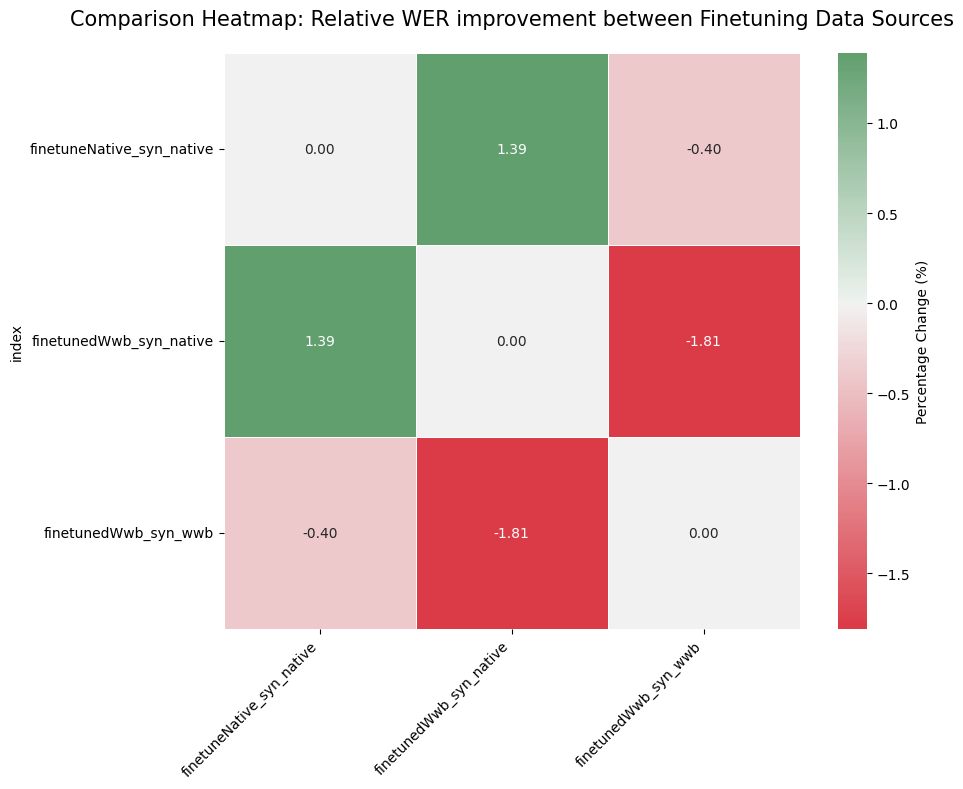

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO

# 1. Prepare the data
# We use StringIO to simulate reading from a file/string
data_string = """
index,finetuneNative_syn_native,finetunedWwb_syn_native,finetunedWwb_syn_wwb
finetuneNative_syn_native,-,1.39%,-0.40%
finetunedWwb_syn_native,1.39%,-,-1.81%
finetunedWwb_syn_wwb,-0.40%,-1.81%,-
"""

# 2. Load into DataFrame
df = pd.read_csv(StringIO(data_string.strip()), )
df.set_index('index', inplace=True)

# 3. Clean the data
# Convert percentage strings to floats and replace '-' with 0
def clean_pct(val):
    if val == '-':
        return 0.0
    return float(val.strip('%'))

df_cleaned = df.applymap(clean_pct)

# 4. Create the Heatmap
plt.figure(figsize=(10, 8))

# Define a diverging color palette (Red-Yellow-Green)
# so negative values are red and positive are green
cmap = sns.diverging_palette(10, 133, as_cmap=True)

# Create the heatmap
ax = sns.heatmap(
    df_cleaned,
    annot=True,          # Show the numeric values in cells
    fmt=".2f",           # Format to 2 decimal places
    cmap=cmap,           # Use our color map
    center=0,            # Ensure 0 is the neutral color
    linewidths=.5,       # Add lines between cells
    cbar_kws={'label': 'Percentage Change (%)'},
    square=True          # Force square cells
)

# 5. Formatting labels
plt.title('Comparison Heatmap: Relative WER improvement between Finetuning Data Sources', pad=20, fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()